#### the faces' latent space is created with pbaylies' awesome StyleGAN encoder (building on original work from Puzer): 

pbaylies repo: https://github.com/pbaylies/stylegan-encoder
StyleGAN paper: https://arxiv.org/abs/1812.04948


#### once was run as

https://colab.research.google.com/github/sifbuilder/eodoes/blob/master/packages/eodoes-do-insights/code/randfaces.ipynb



In [0]:
# will define globals

cnnid = 'randfaces'

autoDownloadImages = 1 # auto run mode - get uri[uri.rfind("/")+1:] files from imgsToAutodownload
uploadRawImages = 0 # manually upload raw images
takePhotoImages = 0 # take photo for raw images

imgsToAutodownload = [
  "https://github.com/sifbuilder/eodoes/raw/master/packages/eodoes-eodo-eofaces/img/amgc.jpg"
]

downloadResults = 0 # download results

emptyspace = 0 # or reset runtime
toSmptyFolders = ["stylegan-encoder", "InterFaceGAN", "output_vectors.npy"]

usegdrive = 0

In [0]:
# would mount gdrive

if usegdrive == 1:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # https://medium.com/@prajwal.prashanth22/google-colab-drive-as-persistent-storage-for-long-training-runs-cb82bc1d5b71
  from keras.callbacks import *
  filepath = "/content/gdrive/My Drive/" + cnnid + "/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  
  # referring to callbacks_list when calling model.fit
  # model.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
  #                   epochs=epochs,
  #                   verbose=1,
  #                   validation_data=(x_test, y_test),
  #                   callbacks=callbacks_list)
  
  # to resume run model.load_weights at 47th epoch having reached max validation accuracy of 90.5% :
  # epoch = 47
  # acc = 0.905
  # model.load_weights("/content/gdrive/My Drive/" + cnnid + "/epochs:" + epoch + "-val_acc:" + acc + ".hdf5")
  
  

In [3]:
# process

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import humanize
import psutil
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 155.8 MB


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [5]:
# runtime type must be GPU enabled

import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image


import tensorflow as tf
tf.VERSION
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [6]:
!pwd

/content


In [0]:
# would clean root folder

if emptyspace == 1:
  print("remove folders %s" %toSmptyFolders)
  for folder in toSmptyFolders:
    print("folder: %s" %folder)
    !rm -r $folder


In [0]:
# stylegan folder signature

signature='encode_images.py'
isExist = os.path.exists(signature)
if isExist:
  print("in stylegan. up to root")
  %cd ..
  

In [9]:
# clone pbaylies stylegan encoder:

path = 'stylegan-encoder'
isExist = os.path.exists(path)
if not isExist:
  print("stylegan-encoder does not exist. will clone")
  !git clone https://github.com/pbaylies/stylegan-encoder
else:
  print("stylegan-encoder already exists. will not clone")

stylegan-encoder does not exist. will clone
Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 453 (delta 0), reused 2 (delta 0), pack-reused 449
Receiving objects: 100% (453/453), 12.61 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (255/255), done.


In [0]:
# cd into the encoder repo folder, then create image folders

if os.path.exists('stylegan-encoder') is True:
    os.chdir('stylegan-encoder')
if os.path.exists('aligned_images') is False:
    os.mkdir('aligned_images')
if os.path.exists('raw_images') is False:
    os.mkdir('raw_images')    

In [11]:

import dnnlib
import dnnlib.tflib as tflib


import config
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()

In [12]:
# pretrained resnet encoder - take image as input and estimate its latent code

!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir -p data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:03, 109MB/s]


In [13]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))

aligned_images contains 0 images ready for encoding!


In [0]:
# clean up the videos-to-generate folder

!rm -f videos/* 

In [15]:
# download the StyleGAN network from NVIDIA trained on faces 
# karras2019stylegan-ffhq-1024x1024.pkl

!gdown https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ

Downloading...
From: https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
To: /content/stylegan-encoder/karras2019stylegan-ffhq-1024x1024.pkl
325MB [00:01, 187MB/s]


In [16]:
# load the stylegan and instantiate the generator


fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

# bsize = 8
bsize = 1
synthesis_kwargs = dict(output_transform=fmt, minibatch_size=bsize) 


model_dir = './'
model_path = 'karras2019stylegan-ffhq-1024x1024.pkl'
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  _G = generator_network
  _D = discriminator_network
  Gs = averaged_generator_network
  
print("StyleGAN loaded")



Loading StyleGAN model from karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded


In [17]:
# show generator model

generator_network.print_layers()


G                               Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

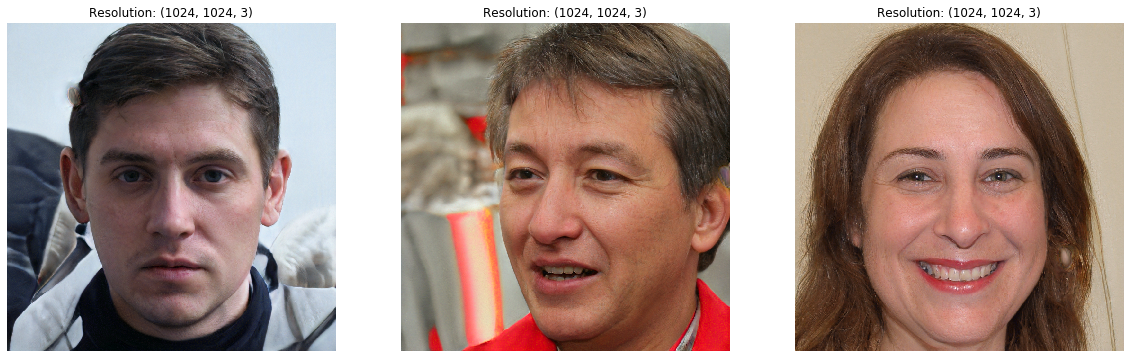

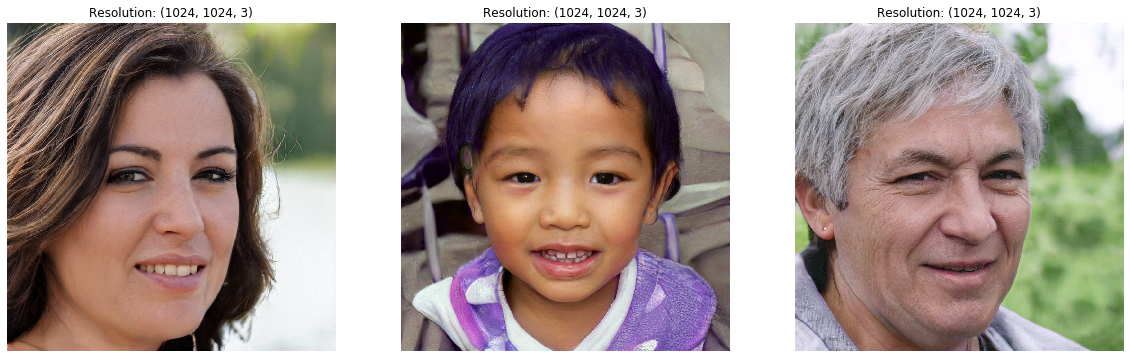

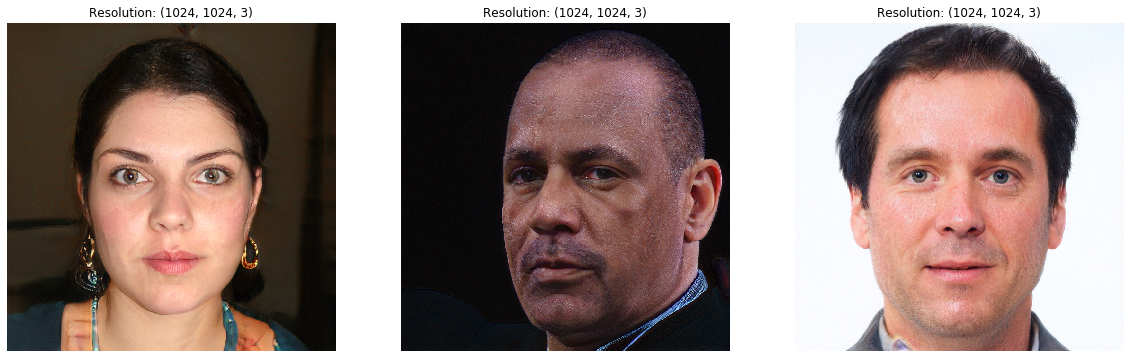

In [18]:
# generate and plot random images

import matplotlib.pyplot as plt
%matplotlib inline

def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=True, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=True, **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  rndvects = {}
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      rndvects[i,j] = np.random.randn(1,512)
      
      img = generate_images(model, rndvects[i,j], z = True)[0]
           
      
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()
    
# random StyleGAN samples:
import numpy as np
plot_imgs(averaged_generator_network, 3, 3)

In [0]:
truncation = 0.5


def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

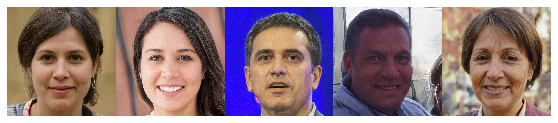

In [20]:
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    plt.axis('off')
    plt.savefig('download.png')
    return images, latents

images, latents = random_sample(5, scale=2)

In [21]:
latents = get_latent_interpolation(latents, 30, 'linear', False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

images = generate_images(latents, labels)    

make_movie(images, '.', 'faves13')


ffmpeg -i frames801367/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./faves13.mp4
